In [1]:
import math
import idx2numpy
import numpy as np
from dataclasses import dataclass
from tqdm import tqdm
from typing import Tuple

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
class MNIST_Dataset:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return dict(
            image=self.images[idx][None, :, :]/255.0,
            label=self.labels[idx]
        )

class PositionEmbeddingSine(nn.Module):
    """
    source: https://github.com/facebookresearch/detr/blob/main/models/position_encoding.py
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.

    Modified: Delete about mask
    """
    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, x):
        N, C, H, W = x.shape
        mask = torch.full((N, H, W), False, dtype=torch.bool, device=x.device)
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * torch.floor(dim_t / 2) / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos

class Conv2d(nn.Module):
    def __init__(self, img_channels, hidden_dim):
        super().__init__()
        self.layer = nn.Conv2d(
            img_channels, 
            hidden_dim, 
            kernel_size=3,
            padding=1
        )

    def forward(self, x):
        return self.layer(x)

class FFN(nn.Module):
    def __init__(self, d_model, d_ff=512, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

class GlobalAveragePooling2D(nn.Module):
    def __init__(self, n_dim, eps=1e-6):
        super().__init__()
        self.norm = nn.LayerNorm(n_dim, eps=eps)

    def forward(self, x):
        return self.norm(x.mean([-2, -1]))

class Transformer(nn.Module):
    def __init__(self, d_model, n_head, d_ff=512, dropout=0.1):
        super().__init__()
        self.att_layer = nn.MultiheadAttention(d_model, n_head, dropout=dropout)
        self.ffn = FFN(d_model, d_ff=d_ff, dropout=dropout)
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    @staticmethod
    def bcwh2nbc(
        x: torch.Tensor
    ) -> torch.Tensor:
        return x.flatten(2).permute(2, 0, 1)

    @staticmethod
    def nbc2bcwh(
        x: torch.Tensor
    ) -> torch.Tensor:
        n, b, c = x.shape
        w = h = math.sqrt(n)
        return x.permute(1, 2, 0).view(b, c, int(w), int(h))

    def forward(
        self,
        x: torch.Tensor,
        p: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.bcwh2nbc(x)
        p = self.bcwh2nbc(p)

        q = k = x + p
        y, score = self.att_layer(q, k, x)
        x = self.norm_1(x+self.dropout_1(y))
        x = self.norm_2(x+self.dropout_2(self.ffn(x)))
        x = self.nbc2bcwh(x)
        return x, score

class Model(nn.Module):
    def __init__(self, img_channels, hidden_dim, n_head, d_ff, dropout, n_class):
        super().__init__()
        self.position_embed = PositionEmbeddingSine(
            num_pos_feats=hidden_dim//2,
            normalize=True
        )
        self.conv = Conv2d(img_channels, hidden_dim)
        self.transformer_1 = Transformer(hidden_dim, n_head, d_ff, dropout)
        self.transformer_2 = Transformer(hidden_dim, n_head, d_ff, dropout)
        self.gap = GlobalAveragePooling2D(hidden_dim)
        self.classfier = nn.Linear(hidden_dim, n_class)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.LayerNorm):
            m.weight.data.fill_(1.0)
            m.bias.data.zero_()            

    def forward(self, x):
        x = self.conv(x)
        p = self.position_embed(x)
        x, score = self.transformer_1(x, p)
        x, score = self.transformer_2(x, p)
        x = self.gap(x)
        x = self.classfier(x)        
        return x, score

In [3]:
# args
@dataclass
class set_args:
    img_channel: int=1
    n_class: int=10
    hidden_dim: int=64
    n_head: int=1
    d_ff: int=128
    dropout: float=0.1
    batch_size: int=32
    num_workers: int=4
    lr: float=1e-3
    epoch: int=3
    device: str="cuda"

args = set_args()

# read data
train_images = idx2numpy.convert_from_file("data/train-images.idx3-ubyte")
train_labels = idx2numpy.convert_from_file("data/train-labels.idx1-ubyte")
test_images = idx2numpy.convert_from_file("data/t10k-images.idx3-ubyte")
test_labels = idx2numpy.convert_from_file("data/t10k-labels.idx1-ubyte")

# dataset
train_dataset = MNIST_Dataset(train_images, train_labels)
test_dataset = MNIST_Dataset(test_images, test_labels)

# dataloader
train_loader = DataLoader(
    train_dataset, 
    batch_size=args.batch_size, 
    num_workers=args.num_workers,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=args.batch_size, 
    num_workers=args.num_workers,
    shuffle=False,
    pin_memory=True,
    drop_last=True
)

# set model
model = Model(args.img_channel, args.hidden_dim, args.n_head, args.d_ff,args.dropout, args.n_class)
model.to(args.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 2], gamma=0.1)
criterion = nn.CrossEntropyLoss()

### Train

In [4]:
def train_one_epoch(epoch, model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = None
    beta = 0.99
    pbar = tqdm(dataloader, desc=f"EPOCH {epoch:03d}")
    for data in pbar:
        image = data["image"].float().to(device)
        label = data["label"].long().to(device)

        y, _ = model(image)
        loss = criterion(y, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if train_loss is None:
            train_loss = loss.item()
        else:
            train_loss = (1-beta)*loss.item() + beta*train_loss
        pbar.set_postfix(
            dict(
                loss=np.mean(train_loss),
                lr=optimizer.param_groups[0]["lr"]
            )
        )
    scheduler.step()

def evaluation(model, dataloader, device):
    model.eval()
    pred = []
    true = []
    for data in dataloader:
        image = data["image"].float().to(device)
        label = data["label"].long().to(device)

        with torch.no_grad():
            y, _ = model(image)

        p = torch.argmax(y, axis=1).cpu().numpy()
        t = label.cpu().numpy()
        pred.append(p)
        true.append(t)

    pred = np.concatenate(pred).astype(int)
    true = np.concatenate(true).astype(int)
    accuracy = np.mean(true==pred)
    print(f"Accuracy: {100*accuracy:.2f} %")

In [5]:
for epoch in range(args.epoch):
    train_one_epoch(epoch, model, train_loader, optimizer, scheduler, criterion, args.device)
    evaluation(model, test_loader, args.device)

EPOCH 000: 100%|██████████| 1875/1875 [01:14<00:00, 25.05it/s, loss=0.249, lr=0.001]


Accuracy: 94.68 %


EPOCH 001: 100%|██████████| 1875/1875 [01:14<00:00, 25.21it/s, loss=0.135, lr=0.0001]


Accuracy: 96.46 %


EPOCH 002: 100%|██████████| 1875/1875 [01:14<00:00, 25.15it/s, loss=0.121, lr=1e-5]


Accuracy: 96.49 %


### Inference

In [6]:
model.eval()
for data in test_loader:
    image = data["image"].float().to(args.device)
    with torch.no_grad():
        y, score = model(image)
        
    I = 255*data["image"]
    I = I.numpy().astype(np.uint8)
    I = I[:, 0, :, :]
    score = score.cpu().numpy()
    p = torch.argmax(y, axis=1).cpu().numpy()
    t = data["label"]
    break

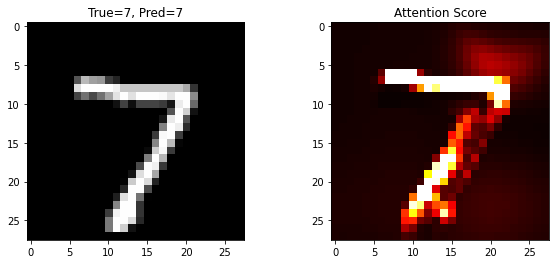

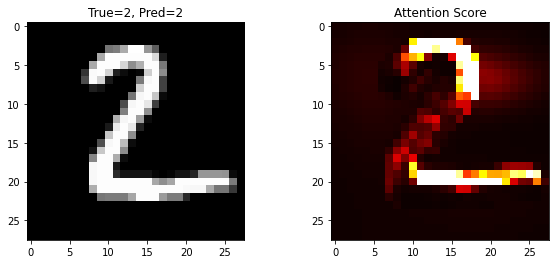

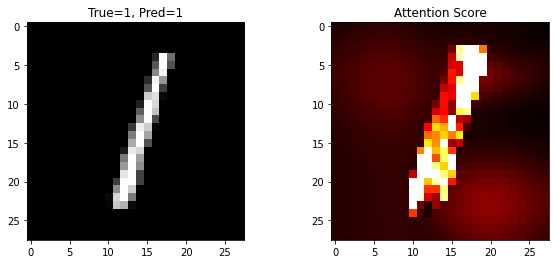

In [7]:
def get_att_map(att_mat):
    att_map = np.mean(att_mat, axis=0)
    att_map = np.minimum(att_map, np.percentile(att_map, 95))
    att_map = 255*(att_map/np.max(att_map))
    att_map = att_map.reshape(28, 28).astype(np.uint8)
    return att_map

for i in range(3):
    pred = p[i]
    true = t[i]

    image = I[i, :, :]
    att_mat = score[i, :, :]
    att_map = get_att_map(att_mat)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"True={true}, Pred={pred}")
    plt.imshow(image, cmap="gray")

    plt.subplot(1, 2, 2)
    plt.title("Attention Score")
    plt.imshow(att_map, cmap="hot")    

    plt.show()